In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import re
import warnings
warnings.filterwarnings('ignore')

# importing the data form csvs

In [90]:
ag_all_bh = pd.read_csv('ag_all_bh.csv')
ag_col_bh = pd.read_csv('ag_col_bh.csv')
ag_merge_bh = pd.read_csv('ag_merge_bh.csv')
ag_col = pd.read_csv('ag_col.csv')
ag_merge = pd.read_csv('ag_merge.csv')


In [91]:
ag_col_bh

,time_x,collision_type,idm,mm,id1,m1,id2,m2,r_x,typem,...,time_y,r_y,binary,ID,zams_m,m_progenitor,bh_mass,bh_spin,birth_kick,model
0,11.565179,single-single,1680002,33.8986,1680001,33.7704,470820,0.129842,0.038822,4,...,11.885657,0.191185,0,1680002,0.000000,17.89330,16.09650,0.0,1.00000,data\N16rv0.5rg2.0Z0.002
1,7.978654,single-single,1680061,133.8740,1680060,179.9130,299190,0.394966,0.013368,4,...,8.287822,0.137582,1,1680061,0.000000,33.00390,29.70350,0.0,0.00000,data\N16rv0.5rg2.0Z0.002
2,3.710148,single-single,1680133,110.5980,1680132,110.4200,261872,0.179723,0.025530,4,...,4.003505,0.144856,1,1680133,0.000000,35.19190,31.67270,0.0,0.00000,data\N16rv0.5rg2.0Z0.002
3,4.100341,single-single,1680220,41.3707,1680219,41.2697,328483,0.105145,0.052498,4,...,4.334216,0.069415,0,1680220,0.341818,34.12200,30.70980,0.0,1.00000,data\N16rv0.5rg2.0Z0.002
4,3.849036,single-single,1680292,52.0011,1680291,51.8734,137163,0.133144,0.041029,4,...,4.083307,0.034394,0,1680292,0.169725,40.61420,36.55280,0.0,1.00000,data\N16rv0.5rg2.0Z0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25558,7.467068,single-single,867397,27.4788,27397,27.2059,34148,0.274166,0.809076,4,...,7.467073,0.809076,0,867397,1.377720,29.83110,12.91490,0.0,196.38100,data\N8.0rv4.0rg8.0Z0.002
25559,8.195550,single-single,935010,21.1569,95010,21.0637,260784,0.094146,1.787344,4,...,8.195555,1.787344,0,935010,0.376952,29.08860,11.89070,0.0,89.37041,data\N8.0rv4.0rg8.0Z0.002
25560,8.195550,single-single,1021125,23.4548,239877,23.3603,181125,0.095204,2.219268,4,...,8.195555,2.219268,0,1021125,0.000000,28.60760,11.48710,0.0,149.45210,data\N8.0rv4.0rg8.0Z0.002
25561,6.479118,single-single,901838,26.2744,61838,26.0639,69692,0.210457,0.995484,1,...,17.584706,1.914572,0,901838,58.609600,8.76791,7.63069,0.0,1.00000,data\N8.0rv4.0rg8.0Z0.02


## Grouping 

## multiindex data frame test

In [92]:
ag_col_bh['int_type'] = pd.Categorical(
    np.select([
        (ag_col_bh['type1'].isin([0,1]) & ag_col_bh['type2'].isin([0,1])),
        (ag_col_bh['type1'].isin(range(2,10)) & ag_col_bh['type2'].isin(range(2,10))),
        ((ag_col_bh['type1'].isin([0,1]) & ag_col_bh['type2'].isin(range(2,10))) | 
         (ag_col_bh['type1'].isin(range(2,10)) & ag_col_bh['type2'].isin([0,1]))),
        ((ag_col_bh['type1'] >= 10) | (ag_col_bh['type2'] >= 10))
    ], ['MS+MS', 'Giant+Giant', 'MS+Giant', 'Other'], default='Unknown'),
    categories=['MS+MS', 'MS+Giant', 'Giant+Giant', 'Other', 'Unknown'],
    ordered=True
)


In [93]:
df_processed = ag_col_bh.copy()

# Mass ratio categories
df_processed['q'] = pd.cut(
    df_processed['mass_ratio'], 
    bins=[0, 0.01, 0.1, 1.0], 
    labels=['0.01', '0.1', '1'],
    include_lowest=True
)

# Type categories
df_processed['type'] = df_processed['typem'].apply(
    lambda x: 'MS' if x in [0, 1] else 'Giant' if x in [2, 3, 4, 5, 6, 7, 8, 9] else 'Other'
)

# Larger mass categories
df_processed['pm'] = pd.cut(
    df_processed['larger_mass'], 
    bins=[0,10, 50, 100, 150], 
    labels=['10','50', '100', '150'],
    include_lowest=True
)

# Create MultiIndex DataFrame
col = df_processed.set_index(['q', 'type', 'pm','int_type'])
col

time_x collision_type      idm        mm      id1  \
q    type  pm  int_type                                                         
0.01 Giant 50  MS+Giant  11.565179  single-single  1680002   33.8986  1680001   
           nan MS+Giant   7.978654  single-single  1680061  133.8740  1680060   
           150 MS+Giant   3.710148  single-single  1680133  110.5980  1680132   
           50  MS+Giant   4.100341  single-single  1680220   41.3707  1680219   
           100 MS+Giant   3.849036  single-single  1680292   52.0011  1680291   
...                            ...            ...      ...       ...      ...   
0.1  Giant 50  MS+Giant   7.467068  single-single   867397   27.4788    27397   
0.01 Giant 50  MS+Giant   8.195550  single-single   935010   21.1569    95010   
               MS+Giant   8.195550  single-single  1021125   23.4548   239877   
     MS    50  MS+MS      6.479118  single-single   901838   26.2744    61838   
     Giant 50  MS+Giant   5.730905  single-single   979285   31.3418   220037   

                               m1     id2        m2       r_x  typem  ...  \
q    type  pm  int_type                                               ...   
0.01 Giant 50  MS+Giant   33.7704  470820  0.129842  0.038822      4  ...   
           nan MS+Giant  179.9130  299190  0.394966  0.013368      4  ...   
           150 MS+Giant  110.4200  261872  0.179723  0.025530      4  ...   
           50  MS+Giant   41.2697  328483  0.105145  0.052498      4  ...   
           100 MS+Giant   51.8734  137163  0.133144  0.041029      4  ...   
...                           ...     ...       ...       ...    ...  ...   
0.1  Giant 50  MS+Giant   27.2059   34148  0.274166  0.809076      4  ...   
0.01 Giant 50  MS+Giant   21.0637  260784  0.094146  1.787344      4  ...   
               MS+Giant   23.3603  181125  0.095204  2.219268      4  ...   
     MS    50  MS+MS      26.0639   69692  0.210457  0.995484      1  ...   
     Giant 50  MS+Giant   31.2379  139285  0.104337  2.409768      4  ...   

                            time_y       r_y  binary       ID     zams_m  \
q    type  pm  int_type                                                    
0.01 Giant 50  MS+Giant  11.885657  0.191185       0  1680002   0.000000   
           nan MS+Giant   8.287822  0.137582       1  1680061   0.000000   
           150 MS+Giant   4.003505  0.144856       1  1680133   0.000000   
           50  MS+Giant   4.334216  0.069415       0  1680220   0.341818   
           100 MS+Giant   4.083307  0.034394       0  1680292   0.169725   
...                            ...       ...     ...      ...        ...   
0.1  Giant 50  MS+Giant   7.467073  0.809076       0   867397   1.377720   
0.01 Giant 50  MS+Giant   8.195555  1.787344       0   935010   0.376952   
               MS+Giant   8.195555  2.219268       0  1021125   0.000000   
     MS    50  MS+MS     17.584706  1.914572       0   901838  58.609600   
     Giant 50  MS+Giant   6.479118  1.671008       0   979285   0.000000   

                         m_progenitor   bh_mass  bh_spin  birth_kick  \
q    type  pm  int_type                                                
0.01 Giant 50  MS+Giant      17.89330  16.09650      0.0     1.00000   
           nan MS+Giant      33.00390  29.70350      0.0     0.00000   
           150 MS+Giant      35.19190  31.67270      0.0     0.00000   
           50  MS+Giant      34.12200  30.70980      0.0     1.00000   
           100 MS+Giant      40.61420  36.55280      0.0     1.00000   
...                               ...       ...      ...         ...   
0.1  Giant 50  MS+Giant      29.83110  12.91490      0.0   196.38100   
0.01 Giant 50  MS+Giant      29.08860  11.89070      0.0    89.37041   
               MS+Giant      28.60760  11.48710      0.0   149.45210   
     MS    50  MS+MS          8.76791   7.63069      0.0     1.00000   
     Giant 50  MS+Giant       9.91991   6.05481      0.0   257.86510   

                                             m

In [94]:
q_list = ['0.01', '0.1', '1']
type_list=['MS','Giant']
pm_list= ['10','50', '100', '150']
int_list=['MS+MS', 'MS+Giant', 'Giant+Giant', 'Other', 'Unknown']
groups = {}
names = []

# # Mass ratio and type m filtering
# for q in q_list:
#     for type in type_list:
#         variable_name = f"col_{q}_{type}"
#         names.append(variable_name)
#         groups[variable_name] = col.loc[q,type,:,:]

# # Mass ratio and interaction type filtering
# for q in q_list:
#     for int in int_list:
#         variable_name = f"col_{q}_{int}"
#         names.append(variable_name)
#         groups[variable_name] = col.loc[q,:,:,int]


# Only interaction type filtering

for int in int_list:
    variable_name = f"col_{int}"
    names.append(variable_name)
    groups[variable_name] = col.loc[:,:,:,int]

        


In [95]:
def sumarise_col(cluster_data):
        col_stats={
        'count': len(cluster_data),
        'percentage': len(cluster_data) / len(col) * 100,
        'avg_smaller_mass': cluster_data['smaller_mass'].mean(),
        'avg_larger_mass': cluster_data['larger_mass'].mean(),
        'avg_mass_ratio': cluster_data['mass_ratio'].mean(),
        'avg_merged_mass': cluster_data['mm'].mean(),
        'median_smaller_mass': cluster_data['smaller_mass'].median(),
        'median_larger_mass': cluster_data['larger_mass'].median(),
        'median_mass_ratio': cluster_data['mass_ratio'].median(),
        'median_merged_mass': cluster_data['mm'].median()

        }

        print("-" * 25) 

        for k, v in col_stats.items():
             print(f"{k:<10} {v:<15}")
        print("-" * 25) 
        return col_stats



In [96]:
groups[names[0]]

time_x collision_type      idm        mm      id1        m1  \
q    type pm                                                                    
0.01 MS   100   3.101171  binary-single  1689424   91.6353     9424   91.5253   
          150   6.892310  single-single  1692519  116.2320  1692518  116.0870   
          100  10.072809  binary-single  1699097   83.2637  1744929   83.1649   
          100   7.483465  binary-single  1706983   94.8166  1706982   94.0114   
0.1  MS   50    4.022658  single-single  1707419   26.0050   692241   25.6419   
...                  ...            ...      ...       ...      ...       ...   
          50    3.199974  single-single  1197979   21.6682   499712   20.7715   
0.01 MS   50    3.670268  single-single   846409   46.5644     6409   46.3995   
          150   1.955391  binary-single   850657  102.5440    10657  102.4460   
          150   1.629516  single-single  1028351  107.5480   188351  107.4230   
          50    6.479118  single-single   901838   26.2744    61838   26.0639   

                   id2        m2       r_x  typem  ...     time_y       r_y  \
q    type pm                                       ...                        
0.01 MS   100   348419  0.109969  0.018274      1  ...   6.718163  0.080643   
          150  1092822  0.145747  0.039486      1  ...  10.572855  0.037041   
          100    19096  0.098736  0.060115      1  ...  13.762736  0.071137   
          100   359722  0.805201  0.056570      1  ...  11.235989  0.171196   
0.1  MS   50     27419  0.363101  0.198374      1  ...  11.975629  1.405015   
...                ...       ...       ...    ...  ...        ...       ...   
          50    357979  0.896735  3.011356      1  ...  13.869639  4.594240   
0.01 MS   50    186356  0.164946  2.474312      1  ...   9.310174  0.343672   
          150    12219  0.097755  0.613264      1  ...   5.648451  0.660296   
          150   215425  0.125133  2.824044      1  ...   5.368345  4.416080   
          50     69692  0.210457  0.995484      1  ...  17.584706  1.914572   

               binary       ID     zams_m  m_progenitor   bh_mass  bh_spin  \
q    type pm                                                                 
0.01 MS   100       0  1689424   0.160949      31.88100  28.69290      0.0   
          150       0  1692519   0.127146      36.38780  32.74900      0.0   
          100       1  1699097   0.000000      28.77680  25.89910      0.0   
          100       0  1706983   0.106141      33.00080  29.70070      0.0   
0.1  MS   50        0  1707419   0.217993      25.74440   8.60303      0.0   
...               ...      ...        ...           ...       ...      ...   
          50        0  1197979   0.000000      21.53020  16.77540      0.0   
0.01 MS   50        0   846409   0.000000      10.73270   6.66235      0.0   
          150       1   850657   0.000000      40.87930  36.79140      0.0   
          150       0  1028351   0.000000     104.15100  40.50000      0.0   
          50        0   901838  58.609600       8.76791   7.63069      0.0   

               birth_kick                       model  
q    type pm                                           
0.01 MS   100     1.00000    data\N16rv0.5rg2.0Z0.002  
          150     1.00000    data\N16rv0.5rg2.0Z0.002  
          100     0.00000    data\N16rv0.5rg2.0Z0.002  
          100     1.00000    data\N16rv0.5rg2.0Z0.002  
0.1  MS   50    247.84410    data\N16rv0.5rg2.0Z0.002  
...                   ...                         ...  
          50      1.00000   data\N8.0rv4.0rg2.0Z0.002  
0.01 MS   50     93.37391    data\N8.0rv4.0rg2.0Z0.02  
          150     0.00000  data\N8.0rv4.0rg20.0Z0.002  
          150     1.00000  data\N8.0rv4.0rg8.0Z0.0002  
          50      1.00000    data\N8.0rv4.0rg8.0Z0.02  

[3071 rows x 25 columns]

In [97]:
group_list=[]
for name in names:

    print(f'Group params {name}')
    sumarise_col(groups[name])
    group_list.append(sumarise_col(groups[name].copy())
)


Group params col_MS+MS
-------------------------
count      3071           
percentage 12.01345694949732
avg_smaller_mass 0.8036139679908825
avg_larger_mass 59.081715971996104
avg_mass_ratio 0.020165477900206452
avg_merged_mass 59.885326310648
median_smaller_mass 0.199938       
median_larger_mass 51.7008        
median_mass_ratio 0.0040506870229007
median_merged_mass 52.2503        
-------------------------
-------------------------
count      3071           
percentage 12.01345694949732
avg_smaller_mass 0.8036139679908825
avg_larger_mass 59.081715971996104
avg_mass_ratio 0.020165477900206452
avg_merged_mass 59.885326310648
median_smaller_mass 0.199938       
median_larger_mass 51.7008        
median_mass_ratio 0.0040506870229007
median_merged_mass 52.2503        
-------------------------
Group params col_MS+Giant
-------------------------
count      22150          
percentage 86.64867190861793
avg_smaller_mass 0.6669368275124153
avg_larger_mass 34.00355099638826
avg_mass_ratio 0.02

In [98]:
group_sum = pd.DataFrame(group_list)
group_sum= group_sum.set_axis(names).round(3)
group_sum

,count,percentage,avg_smaller_mass,avg_larger_mass,avg_mass_ratio,avg_merged_mass,median_smaller_mass,median_larger_mass,median_mass_ratio,median_merged_mass
col_MS+MS,3071,12.013,0.804,59.082,0.020,59.885,0.200,51.701,0.004,52.250
col_MS+Giant,22150,86.649,0.667,34.004,0.023,33.918,0.209,26.104,0.008,26.302
col_Giant+Giant,54,0.211,23.197,33.898,0.749,56.283,19.037,26.193,0.809,44.944
col_Other,3,0.012,1.190,12.853,0.096,14.037,1.182,12.880,0.088,14.014
col_Unknown,285,1.115,1.647,78.878,0.030,74.066,0.196,65.193,0.003,63.329


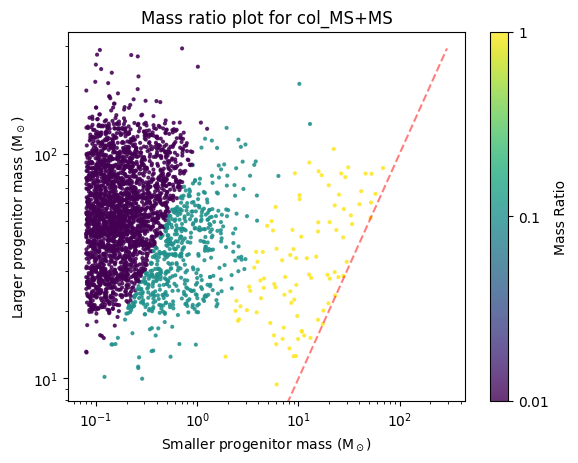

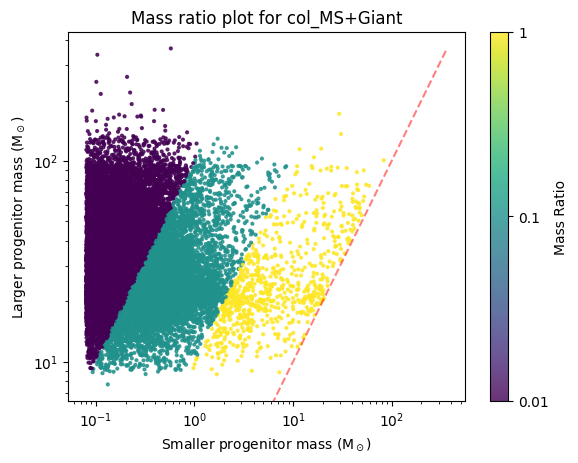

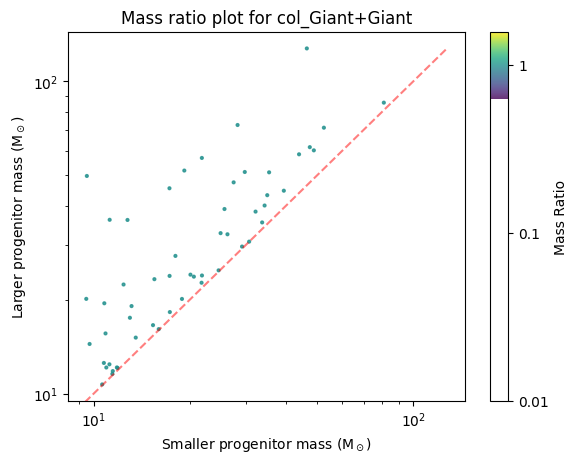

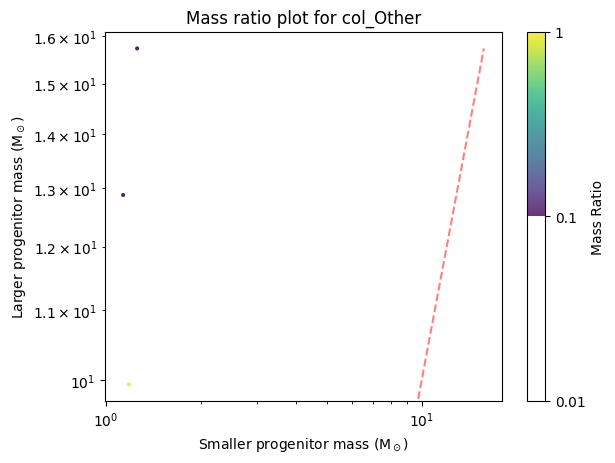

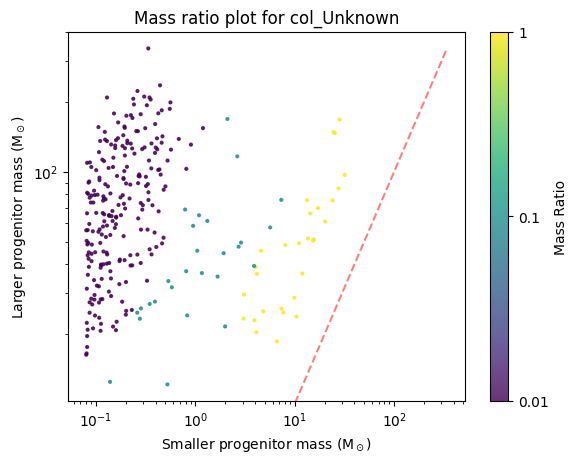

In [99]:
for name in names:
    col_plot = groups[name].copy()
    plt.figure()
    
    # Create categorical bins
    col_plot['q'] = pd.cut(
        col_plot['mass_ratio'], 
        bins=[0, 0.01, 0.1, 1.0], 
        labels=['0.01', '0.1', '1'],
        include_lowest=True
    )
    
    # Convert categorical to numerical codes 
    sc = plt.scatter(col_plot['smaller_mass'], col_plot['larger_mass'], 
                     c=col_plot['q'].cat.codes, cmap='viridis', alpha=.8, s=4)
    
    maxi = col_plot['larger_mass'].max()
    plt.plot([0,maxi],[0,maxi],'r--',alpha=.5)
    
    # Create colorbar  labels
    cb = plt.colorbar(sc)
    cb.set_label('Mass Ratio')
    cb.set_ticks([0, 1, 2])  
    cb.set_ticklabels(['0.01', '0.1', '1'])
    
    plt.xlabel('Smaller progenitor mass (M$_\odot$)')
    plt.ylabel('Larger progenitor mass (M$_\odot$)')
    plt.yscale('log')
    plt.xscale('log')
    plt.title(f'Mass ratio plot for {name}')
    plt.show()


In [100]:
col_test = groups[names[0]]
col_test = col_test.reset_index()
median_mass_ratio_overall = col_test['mass_ratio'].median()
median_idx_overall = (col_test['mass_ratio'] - median_mass_ratio_overall).idxmin()
median_idx_overall
col_test.loc[median_idx_overall]


q                                        0.01
type                                       MS
pm                                        NaN
time_x                              10.536519
collision_type                  binary-single
idm                                    851767
mm                                     275.34
id1                                    851766
m1                                    275.238
id2                                    625620
m2                                   0.102344
r_x                                  0.029393
typem                                       1
type1                                       1
type2                                       0
smaller_mass                         0.102344
larger_mass                           275.238
mass_ratio                           0.000372
time_y                              13.788295
r_y                                  0.057341
binary                                      1
ID                                

# groups plotted

In [101]:
def median_line(col_plot):
        # Median mass ratio line (LIMITED to data range)
        median_mass_ratio_overall = col_plot['mass_ratio'].median()
        
        # Get actual data limits
        x_min = col_plot['smaller_mass'].min()
        x_max = col_plot['smaller_mass'].max()
        y_min = col_plot['larger_mass'].min()
        y_max = col_plot['larger_mass'].max()
        
        # Create x range for the line
        x_range = np.logspace(np.log10(x_min), np.log10(x_max), 100)
        y_line = x_range / median_mass_ratio_overall
        
        # LIMIT the line 
        mask = (y_line >= y_min) & (y_line <= y_max)
        x_line_limited = x_range[mask]
        y_line_limited = y_line[mask]
        
        # Plot only the limited portion of the line
        plt.plot(x_line_limited, y_line_limited, 'k-', linewidth=2, label=f'Median Mass Ratio = {median_mass_ratio_overall:.3f}', zorder=4)

In [114]:
def median_point(df):

    # Calculate median values for both masses
    med_smaller = df['smaller_mass'].median()
    med_larger = df['larger_mass'].median()
    
    # Calculate standard deviations for error bars
    std_smaller = df['smaller_mass'].std()
    std_larger = df['larger_mass'].std()
    
    # Plot median point with error bars
    plt.errorbar(med_smaller, med_larger, 
                 xerr=std_smaller, yerr=std_larger,
                 fmt='o', color='red', ecolor='indianred', 
                 elinewidth=2, capsize=4, markersize=8,
                 label='Median ± 1σ', zorder=5)
    plt.xscale('log')
    plt.yscale('log')


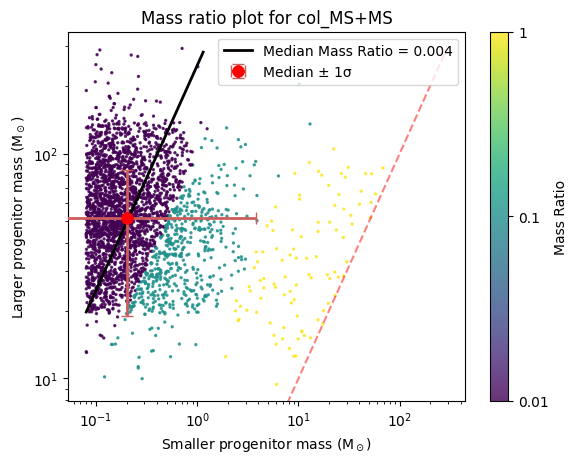

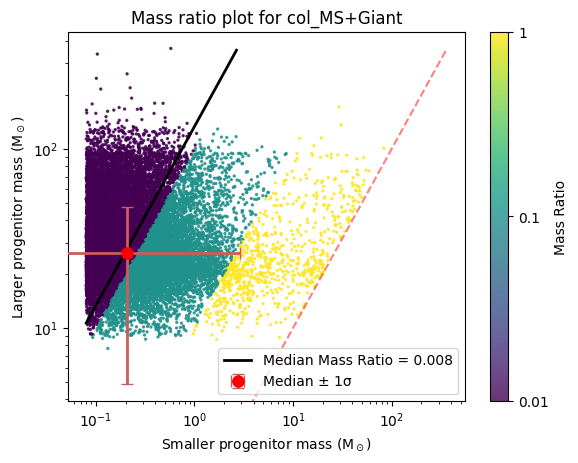

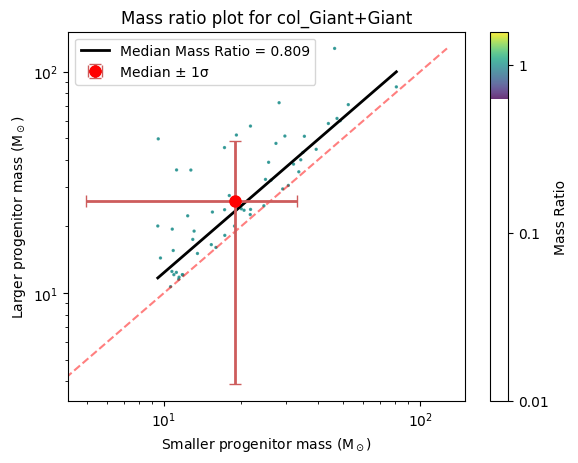

In [117]:
for name in names[:3]:
    col_plot = groups[name].copy()
    plt.figure()
    col_plot = col_plot.reset_index()
    
    # Create categorical bins
    col_plot['q'] = pd.cut(
        col_plot['mass_ratio'], 
        bins=[0, 0.01, 0.1, 1.0], 
        labels=['0.01', '0.1', '1'],
        include_lowest=True
    )
    
    # Convert categorical to numerical codes 
    sc = plt.scatter(col_plot['smaller_mass'], col_plot['larger_mass'], 
                     c=col_plot['q'].cat.codes, cmap='viridis', alpha=.8, s=2)
    
    maxi = col_plot['larger_mass'].max()
    plt.plot([0,maxi],[0,maxi],'r--',alpha=.5)
    
    # Create colorbar labels
    cb = plt.colorbar(sc)
    cb.set_label('Mass Ratio')
    cb.set_ticks([0, 1, 2])  
    cb.set_ticklabels(['0.01', '0.1', '1'])

        
    #making over all median line and pont
    median_line(col_plot)
    median_point(col_plot)




    
    plt.xlabel('Smaller progenitor mass (M$_\odot$)')
    plt.ylabel('Larger progenitor mass (M$_\odot$)')
    plt.yscale('log')
    plt.xscale('log')
    plt.title(f'Mass ratio plot for {name}')
    plt.legend()
    plt.show()
